## Herso 1 sailing alone
### Estimate Fuel use with vessel speed, h_0, current speed as input

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages



### create graph with navigation info

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4366,0],
    [0.8528,0], 
    [1.1443,0],
    [1.31495,0],
    [1.56274,0],
    [1.736384,0],
    [2.0710,0], 
    [2.20665,0],
    [3.05674,0],
    [3.32804,0],
    [4.1148,0],
    [4.54888,0], 
    [4.73879,0],
    [5.07844,0],
    [6.62475,0], 
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [7.5, 4.18, 4.18, 7.83, 7.5, 6.5, 10.6, 6.45, 8.04, 5.65, 8.87, 4.93, 7.7, 9.8, 5.45]
current_speeds = [-2.24* 0.2777,-3.4* 0.2777,-4.93* 0.2777,-2.59* 0.2777,-3.26* 0.2777,
                     -3.85* 0.2777,-1.87* 0.2777,-1.08* 0.2777,-2.83* 0.2777,-4.99* 0.2777,
                     -2.89* 0.2777,-6.4* 0.2777,-3.42* 0.2777,-1.64* 0.2777,-4.1* 0.2777]  # [m/s]

V_g_profile_up = [4.361618,3.545952,3.120952,4.277794,4.078284,3.760506,4.618420,4.507951,
4.233642,3.495985,4.244119,2.925416,4.042063,3.302698,3.632716]

V_g_profile_down = [4.44, 4.44, 4.44, 4.44,4.44, 4.44, 4.44, 4.44, 4.44, 4.44,4.44, 4.44, 4.44, 3.33, 4.44] # [m/s] for downstream

# power_applied = [620, 620, 620, 620, 620, 620, 620, 620, 620,620, 620, 620,620, 250, 620] ## [kW] for upstream
# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

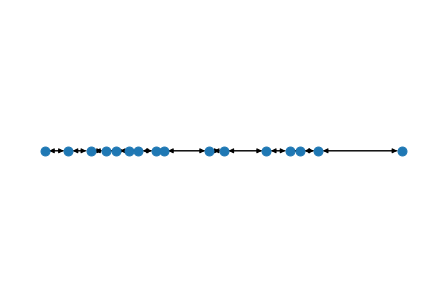

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {} m/s'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing upstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_upstream"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing downstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_downstream"]))

General depth for edge ('Node 0', 'Node 1') is 7.5 m
Current speed for edge ('Node 0', 'Node 1') is -0.622048 m/s
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 4.361618 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 0') is 7.5 m
Current speed for edge ('Node 1', 'Node 0') is -0.622048 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 4.361618 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 2') is 4.18 m
Current speed for edge ('Node 1', 'Node 2') is -0.94418 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 3.545952 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 4.44 m/s while sailing downstream
General depth for edge ('Node 2', 'Node 1') is 4.18 m
Current speed for edge ('Node 2', 'Node 1') is -0.94418 m/

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel_up = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":4.4,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



In [8]:
# Create a dict with all important settings

data_vessel_down = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":4.44,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



### define sailing paths

In [9]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[15].name)
path_downstream = nx.dijkstra_path(FG, nodes[15].name, nodes[0].name)

### define simulation "Herso 1 sailing upstream and downstream"

In [10]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

### run simulation to get energy consumption

### upstream energy consumption

In [11]:
vessel_upstream = run_simulation(path = path_upstream, **data_vessel_up)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_upstream)
energycalculation_upstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
selected = ['edge_start','edge_stop','P_tot','P_installed','total_energy','total_diesel_consumption_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_upstream = df_upstream[selected]
df_upstream

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_energy,total_diesel_consumption_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_LH2_consumption_PEMFC_mass,total_LH2_consumption_SOFC_mass,total_LH2_consumption_PEMFC_vol,total_LH2_consumption_SOFC_vol,total_eLNG_consumption_PEMFC_mass,total_eLNG_consumption_SOFC_mass,total_eLNG_consumption_PEMFC_vol,total_eLNG_consumption_SOFC_vol,total_eLNG_consumption_ICE_mass,total_eLNG_consumption_ICE_vol,total_eMethanol_consumption_PEMFC_mass,total_eMethanol_consumption_SOFC_mass,total_eMethanol_consumption_PEMFC_vol,total_eMethanol_consumption_SOFC_vol,total_eMethanol_consumption_ICE_mass,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (0 0),POINT (0.4366 0),581.639607,780.0,1800.357645,4.063295e+05,0.476857,1.362243e+06,1059.541051,19054.985316,142971.344525,130956.945825,1.862655,1.706129,3.579658e+05,3.278847e+05,0.844289,0.773340,3.565312e+05,0.840905,8.703740e+05,7.972333e+05,1.098764,1.006431,8.668858e+05,1.094361,9.316919e+05,8.533985e+05,1.516708,1.389253,9.279580e+05,1.510629,2.045861e+07,16.190267,1.125224
1,POINT (0.4366 0),POINT (0.8528 0),581.477674,780.0,2110.430127,4.763307e+05,0.559008,1.596926e+06,1242.076549,22336.792463,167595.051789,153511.433991,2.183457,1.999973,4.196177e+05,3.843557e+05,0.989699,0.906531,4.179533e+05,0.985774,1.020277e+06,9.345394e+05,1.288003,1.179767,1.016230e+06,1.282894,1.092156e+06,1.000378e+06,1.777928,1.628522,1.087824e+06,1.770876,2.398216e+07,18.978688,1.319019
2,POINT (0.8528 0),POINT (1.1443 0),581.371373,780.0,1679.089412,3.789861e+05,0.444767,1.270573e+06,988.241927,17771.482338,133341.101134,122135.966585,1.737190,1.591208,3.338540e+05,3.057991e+05,0.787420,0.721250,3.325389e+05,0.784318,8.117475e+05,7.435334e+05,1.024754,0.938640,8.085498e+05,1.020717,8.689352e+05,7.959154e+05,1.414546,1.295676,8.655122e+05,1.408973,1.908056e+07,15.099725,1.049431
3,POINT (1.1443 0),POINT (1.31495 0),581.624931,780.0,717.460755,1.619270e+05,0.190033,5.428697e+05,422.239459,7593.604630,56975.528748,52187.669190,0.742287,0.679910,1.426530e+05,1.306654e+05,0.336458,0.308184,1.420818e+05,0.335111,3.468529e+05,3.177056e+05,0.437869,0.401073,3.454641e+05,0.436116,3.712887e+05,3.400879e+05,0.604423,0.553632,3.698021e+05,0.602003,8.152963e+06,6.451985,0.448413
4,POINT (1.31495 0),POINT (1.56274 0),581.605253,780.0,1092.706032,2.466191e+05,0.289425,8.268048e+05,643.081833,11565.200647,86774.786692,79482.787810,1.130517,1.035515,2.172632e+05,1.990058e+05,0.512431,0.469370,2.163944e+05,0.510382,5.282633e+05,4.838715e+05,0.666882,0.610842,5.261509e+05,0.664215,5.654795e+05,5.179602e+05,0.920548,0.843191,5.632182e+05,0.916867,1.241711e+07,9.826493,0.682941
5,POINT (1.56274 0),POINT (1.736384 0),581.573511,780.0,830.399010,1.874191e+05,0.219950,6.283332e+05,488.712365,8788.943127,65944.265764,60402.730826,0.859133,0.786937,1.651086e+05,1.512339e+05,0.389421,0.356696,1.644497e+05,0.387867,4.014523e+05,3.677168e+05,0.506795,0.464207,3.998502e+05,0.504773,4.297346e+05,3.936225e+05,0.699568,0.640781,4.280197e+05,0.696776,9.436352e+06,7.467617,0.518999
6,POINT (1.736384 0),POINT (2.071 0),581.647673,780.0,1303.112719,2.941038e+05,0.345152,9.860000e+05,766.902350,13792.145020,103483.759484,94787.645242,1.348204,1.234909,2.590984e+05,2.373255e+05,0.611103,0.559750,2.580595e+05,0.608653,6.299834e+05,5.770436e+05,0.795294,0.728463,6.274573e+05,0.792105,6.743658e+05,6.176964e+05,1.097805,1.005552,6.716618e+05,1.093403,1.480810e+07,11.718640,0.814445
7,POINT (2.071 0),POINT (2.20665 0),581.676544,780.0,541.241231,1.221536e+05,0.143356,4.095271e+05,318.526581,5728.497185,42981.452415,39369.565657,0.559970,0.512913,1.076152e+05,9.857192e+04,0.253818,

#### upstream_total_diesel_use [kg] of main engine

In [12]:
upstream_total_diesel_use = (df_upstream['total_diesel_consumption_ICE_mass']/1000).sum() #kg
upstream_total_diesel_use

6841.325140092932

In [13]:
(6841-6609)/6841 # difference compared with the results from paper (Schweighofer & Suvacarov, 2018)

0.03391317058909516

### downstream energy consumption

In [14]:
vessel_downstream = run_simulation(path = path_downstream, **data_vessel_down)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_downstream = opentnsim.energy.EnergyCalculation(FG, vessel_downstream)
energycalculation_downstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_downstream = pd.DataFrame.from_dict(energycalculation_downstream.energy_use)
selected = ['edge_start','edge_stop','P_tot','P_installed','total_energy','total_diesel_consumption_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_downstream = df_downstream[selected]
df_downstream

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_energy,total_diesel_consumption_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_LH2_consumption_PEMFC_mass,total_LH2_consumption_SOFC_mass,total_LH2_consumption_PEMFC_vol,total_LH2_consumption_SOFC_vol,total_eLNG_consumption_PEMFC_mass,total_eLNG_consumption_SOFC_mass,total_eLNG_consumption_PEMFC_vol,total_eLNG_consumption_SOFC_vol,total_eLNG_consumption_ICE_mass,total_eLNG_consumption_ICE_vol,total_eMethanol_consumption_PEMFC_mass,total_eMethanol_consumption_SOFC_mass,total_eMethanol_consumption_PEMFC_vol,total_eMethanol_consumption_SOFC_vol,total_eMethanol_consumption_ICE_mass,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (6.62475 0),POINT (5.07844 0),148.049160,780.0,1594.366837,415657.118901,0.487804,1.393514e+06,1163.731033,19186.808181,106397.520008,112781.371209,1.386165,1.469335,266393.790698,282377.418140,0.628310,0.666008,364715.682525,0.860209,647721.648314,686584.947213,0.817687,0.866748,886785.845992,1.119483,693353.701816,734954.923925,1.128715,1.196438,949259.995612,1.545307,1.811780e+07,14.337831,0.996479
1,POINT (5.07844 0),POINT (4.73879 0),90.306551,780.0,284.823195,77107.239603,0.090491,2.585065e+05,261.840018,3956.947655,27723.546660,24961.147133,0.361187,0.325198,69413.090508,62496.706730,0.163716,0.147403,67657.254599,0.159575,168774.059189,151957.257681,0.213061,0.191832,164504.842078,0.207672,180664.208173,162662.661353,0.294105,0.264800,176094.224299,0.286665,3.236627e+06,2.561360,0.178014
2,POINT (4.73879 0),POINT (4.54888 0),164.555538,780.0,217.643688,56224.989575,0.065984,1.884975e+05,153.392299,2564.981127,14524.103274,15395.549470,0.189222,0.200576,36364.860076,38546.751681,0.085769,0.090915,49334.257770,0.116359,88419.129619,93724.277396,0.111621,0.118318,119953.496954,0.151430,94648.265952,100327.161909,0.154079,0.163323,128404.232552,0.209030,2.473224e+06,1.957227,0.136027
3,POINT (4.54888 0),POINT (4.1148 0),79.195230,780.0,239.416754,65276.270925,0.076606,2.188425e+05,232.784832,3451.367829,26353.682487,22666.074496,0.343340,0.295297,65983.280211,56750.397047,0.155626,0.133850,57276.246744,0.135090,160434.666691,137985.426092,0.202533,0.174193,139264.000310,0.175808,171737.304658,147706.512862,0.279572,0.240452,149075.162759,0.242680,2.720645e+06,2.153028,0.149635
4,POINT (4.1148 0),POINT (3.32804 0),184.264209,780.0,1009.645700,258525.747418,0.303399,8.667225e+05,690.155051,11678.490564,67377.090432,71419.715858,0.877800,0.930468,168696.023413,178817.784818,0.397882,0.421755,226841.764840,0.535023,410174.974661,434785.473141,0.517807,0.548875,551553.102809,0.696283,439071.841761,465416.152266,0.714768,0.757654,590410.072870,0.961133,1.147325e+07,9.079548,0.631029
5,POINT (3.32804 0),POINT (3.05674 0),117.604284,780.0,222.207482,59103.761052,0.069363,1.981488e+05,175.719772,2805.210840,14828.660773,15718.380419,0.193190,0.204782,37127.398777,39355.042703,0.087568,0.092822,51860.217404,0.122316,90273.199951,95689.591948,0.113961,0.120799,126095.226961,0.159183,96632.955720,102430.933063,0.157309,0.166748,134978.648039,0.219733,2.525085e+06,1.998269,0.138880
6,POINT (3.05674 0),POINT (2.20665 0),187.019247,780.0,1107.227722,283159.443861,0.332308,9.493083e+05,753.573272,12773.424314,73889.070511,78322.414742,0.962639,1.020398,185000.454739,196100.482023,0.436337,0.462518,248456.444350,0.586003,449818.290316,476807.387735,0.567853,0.601924,604107.990834,0.762629,481508.032882,510398.514855,0.783850,0.830881,646667.457898,1.052714,1.258213e+07,9.957084,0.692017
7,POINT (2.20665 0),POINT (2.071 0),309.680096,780.0,292.562616,70669.295893,0.082936,2.369229e+05,181.012533,3224.749306,20843.902521,20258.191577,0.271558,0

#### downstream_total_diesel_use [kg] of main engine

In [15]:
downstream_total_diesel_use = (df_downstream['total_diesel_consumption_ICE_mass']/1000).sum() #kg
downstream_total_diesel_use

1976.9930247456844

In [16]:
(1976-1773)/1976 # difference compared with the results from paper (Schweighofer & Suvacarov, 2018)

0.1027327935222672

#### roundtrip_total_diesel_use [kg] of main engine

In [17]:
roundtrip_total_diesel_use = upstream_total_diesel_use + downstream_total_diesel_use
roundtrip_total_diesel_use

8818.318164838616

In [18]:
(8818-8328)/8818 # difference compared with the results from paper (Schweighofer & Suvacarov, 2018)

0.055568156044454524